<a href="https://colab.research.google.com/github/Moshekwa/MultiClass-Text-Classification/blob/main/LTSM_Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
nltk.download('all')
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
!pip install np_utils

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
df = pd.read_excel('/content/WorkingsWinbackSentiments.xlsx')
df.head()

,Template,Membership Number,Suggestions / Compliments / Complaints,Similar Service,Affordability,Unemployed /Lost Job,No Car / Not Driving,Emigrating / Not in Country,Poor Service,Less CallOuts,Separated,Service Not Used,Not Interested,Callback Requested,Not Answered / Voice Mail,Hung Up,Invalid No,Status,Text Analysis
0,T1,524420912,client was not answering her calls i am on the...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Closed Unsuccessful,Not Answered / Voice Mail
1,T1,532863208,the client is going through retrenchment and s...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed Successful,Unemployed /Lost Job
2,T1,532910451,the client is mostly out of the country so he...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed Successful,Emigrating / Not in Country
3,T1,532974190,client is currently unemployed at the moment a...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed Successful,Unemployed /Lost Job
4,T1,532999746,client is going through a rough financial situ...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed Successful,Affordability


In [4]:
data = df[['Suggestions / Compliments / Complaints','Text Analysis']]
data = data.dropna()

In [78]:
data['Text Analysis'].unique()

array(['Not Answered / Voice Mail', 'Unemployed /Lost Job',
       'Emigrating / Not in Country', 'Affordability', 'Not Interested',
       'Similar Service', 'No Comments', 'No Car / Not Driving',
       'Hung Up', 'Separated', 'Poor Service', 'Callback Requested',
       'Invalid No', 'Service Not Used', 'Less CallOuts'], dtype=object)

# Data preprocessing

In [5]:
# Word Count Prior Preprocessing
print(df['Suggestions / Compliments / Complaints'].apply(lambda x: len(x.split(' '))).sum())

6254


In [6]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ', text)
    text = extra_symbol_remover.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
data['Suggestions / Compliments / Complaints'] = data['Suggestions / Compliments / Complaints'].apply(clean_text)

In [7]:
# Word Count After Preprocessing
print(df['Suggestions / Compliments / Complaints'].apply(lambda x: len(x.split(' '))).sum())

6254


# Build & Train the model

## Tokenization

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Suggestions / Compliments / Complaints'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(data['Suggestions / Compliments / Complaints'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(data['Text Analysis']).values
print('Shape of label tensor:', Y.shape)

Found 604 unique tokens.
Shape of data tensor: (343, 250)
Shape of label tensor: (343, 15)


In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(308, 250) (308, 15)
(35, 250) (35, 15)


In [83]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(250, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dense_8 (Dense)              (None, 15)                3765      
Total params: 5,354,765
Trainable params: 5,354,765
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
5/5 [==============================] - 10s 1s/step - loss: 2.6827 - accuracy: 0.1733 - val_loss: 2.6219 - val_accuracy: 0.1613
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 2.5792 - accuracy: 0.1986 - val_loss: 2.6215 - val_accuracy: 0.1613
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 2.4099 - accuracy: 0.1769 - val_loss: 2.4678 - val_accuracy: 0.1613
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 2.3381 - accuracy: 0.1841 - val_loss: 2.5114 - val_accuracy: 0.1613
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 2.2927 - accuracy: 0.1949 - val_loss: 2.5135 - val_accuracy: 0.1613
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 2.2785 - accuracy: 0.2635 - val_loss: 2.4547 - val_accuracy: 0.2581
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 2.2368 - accuracy: 0.3610 - val_loss: 2.4266 - val_accuracy: 0.3226
Epoch 8/20
5/5 [========================

# Performance Metrics

In [85]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 0s 123ms/step - loss: 1.2890 - accuracy: 0.6000
Test set
  Loss: 1.289
  Accuracy: 0.600


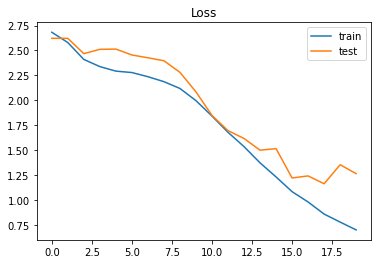

In [86]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

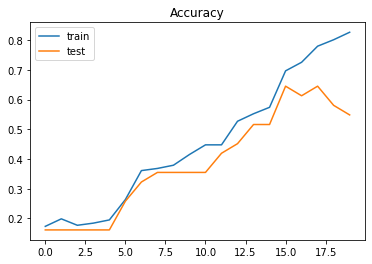

In [87]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Number of Epochs Analysis

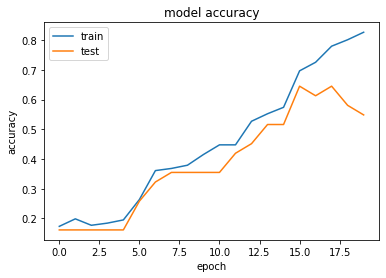

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

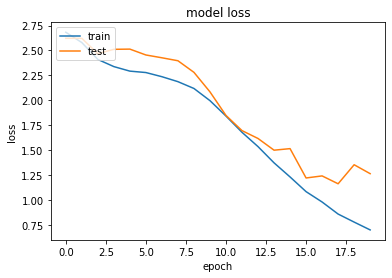

In [89]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
new_complaint = ["client does not work anymore, he is jobless"]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
labels = ['Not Answered / Voice Mail', 'Unemployed /Lost Job',
       'Emigrating / Not in Country', 'Affordability', 'Not Interested',
       'Similar Service', 'No Comments', 'No Car / Not Driving',
       'Hung Up', 'Separated', 'Poor Service', 'Callback Requested',
       'Invalid No', 'Service Not Used', 'Less CallOuts']
print(pred, labels[np.argmax(pred)])

[[0.06862942 0.05445111 0.03728058 0.0866112  0.07406592 0.00572785
  0.04926409 0.23488696 0.04062489 0.11309389 0.00969079 0.00352875
  0.00907802 0.07573255 0.13733394]]
[[0.06862942 0.05445111 0.03728058 0.0866112  0.07406592 0.00572785
  0.04926409 0.23488696 0.04062489 0.11309389 0.00969079 0.00352875
  0.00907802 0.07573255 0.13733394]] No Car / Not Driving


In [92]:
from keras.models import load_model
model.save('Lstm_classification.h5')
lstm = load_model('/content/Lstm_classification.h5')